# Лабораторная работа №3

## 3.1. Марковская гамильтонова динамика с декогеренцией

In [1]:
import numpy as np
from scipy.linalg import expm
from scipy.linalg import sqrtm
import copy

Сгенерируем случайное чистое состояние $|\psi \rangle$ размерности $d$.

In [2]:
d = 2
phys_ind = [d]
state = np.random.randn(*phys_ind) + 1j * np.random.randn(*phys_ind)
psi_0 = state / np.sqrt(np.sum(state * np.conjugate(state)))

Сгенерируем соответствующую состоянию $|\psi\rangle$ матрицу плотности $\rho = |\psi\rangle \langle \psi |$.

In [3]:
psi_0 = np.reshape(psi_0, [2, 1])
rho_0 = np.dot(np.reshape(psi_0, [2, 1]), np.reshape(psi_0, [1, 2]).conjugate())

Класс $\operatorname{Ham}()$ отвечает за вычисление Гамильтониана в определённый момент времени и вычисление коммутатора Гамильтониана с матрицей плотности $\rho$.

In [4]:
class Ham(object):
    def __init__(self):
        self.sigma_x = np.array([[0, 1],
                                 [1, 0]], dtype=complex)
        self.sigma_y = np.array([[0, -1j],
                                 [1j, 0]], dtype=complex)
        self.sigma_z = np.array([[1, 0],
                                 [0, -1]], dtype=complex)
        self.hams = [self.sigma_x, self.sigma_z]
    
    def get_ham(self, t):
        return np.sin(2 * t) * self.hams[0] + np.cos(4 * t) * self.hams[1]
    
    def get_comm(self, rho, t):
        ham = self.get_ham(t)
        return np.dot(ham, rho) - np.dot(rho, ham)

In [5]:
class Lindblad(object):
    def __init__(self, T2):
        self.T2 = T2
        G = 1 / self.T2
        self.sigma_z = np.array([[1, 0],
                                 [0, -1]], dtype=complex)
        self.lindblad = (np.sqrt(G) / np.sqrt(2)) * self.sigma_z
    
    def get_anti_comm(self, rho):
        return (1 / 2) * (self.lindblad.T.conjugate() @ self.lindblad @ rho + rho @ self.lindblad.T.conjugate() @ self.lindblad)
    
    def get_l_rho_l(self, rho):
        return self.lindblad @ rho @ self.lindblad.T.conjugate()
    
    def get_list_kraus(self, dt):
        gamma = 1 - np.exp(-(2 * dt) / self.T2)
        E_0 = np.array([[1, 0], 
                        [0, np.sqrt(1 - gamma)]], dtype=complex)
        E_1 = np.array([[0, 0], [0, np.sqrt(gamma)]], dtype=complex)
        return [E_0, E_1]

Класс $\operatorname{Evolution}()$ отвечает за вычисление эволюции матрицы плотности $\rho(t)$ при заданной начальной матрице плотности $\rho_0$. Метод класса evolution_ODE() вычисляет эволюцию матрицы плотности с использованием численного решения (метода конечных разностей) уравнения Линдблада: $\dfrac{\partial \rho}{\partial t} = -i [H, \rho] - \dfrac{1}{2}\sum_k \{ L^{\dagger}_k L_k \rho \} + \sum_k L_k \rho L^{\dagger}_k$. Метод класса evolution_EXPM() вычисляет эволюцию матрицы плотности с использованием оператора унитарной эволюции на малых временных шагах, на которых мы считаем Гамильтониан постоянным: $U(t, t + \Delta t) = \exp{(-i H(t) \Delta t)}$, при этом $\rho(t + \Delta t) = U(t, t + \Delta t) \rho(t) U^{\dagger}(t, t + \Delta t)$, а затем производим динамику, используя операторы Крауса: $\rho(t + \Delta t) = \sum_k E_k(t, t + \Delta t) \rho(t) E^{\dagger}_k(t, t + \Delta t)$.

In [6]:
class Evolution(object):
    def __init__(self):
        self.rho = None
        self.ham = None
        self.lindblad = None
        self.list_rho = None
        self.final_rho = None
    
    def set_rho(self, rho):
        self.rho = copy.copy(rho)
    
    def set_ham(self, ham):
        self.ham = ham
    
    def set_lindblad(self, lindblad):
        self.lindblad = lindblad
    
    def evolution_ODE(self, time_evolution, dt):
        self.list_rho = [copy.copy(self.rho)]
        t = 0
        while (t < time_evolution):
            self.rho += -1j * self.ham.get_comm(self.rho, t) * dt - self.lindblad.get_anti_comm(self.rho) * dt + \
            self.lindblad.get_l_rho_l(self.rho) * dt
            self.list_rho.append(copy.copy(self.rho))
            t += dt
        self.final_rho = self.list_rho[-1]
    
    def evolution_EXPM(self, time_evolution, dt):
        self.list_rho = [copy.copy(self.rho)]
        t = 0
        while (t < time_evolution):
            U = expm(-1j * self.ham.get_ham(t) * dt)
            self.rho = np.dot(U, np.dot(self.rho, np.conjugate(U).T))
            list_kraus = self.lindblad.get_list_kraus(dt)
            rho_new = np.zeros((2, 2), dtype=complex)
            for kraus in list_kraus:
                rho_new += kraus @ self.rho @ kraus.T.conjugate()
            self.rho = rho_new
            self.list_rho.append(copy.copy(self.rho))
            t += dt
        self.final_rho = self.list_rho[-1]
            
    
    def get_rho(self):
        return self.rho
    
    def get_list_rho(self):
        return self.list_rho
    
    def get_final_rho(self):
        return self.final_rho

Добавим вспомогательную функцию, которая будет считать фиделити между двумя смешанными квантовыми состояниями.

In [7]:
def fidelity(rho, sigma):
    return np.abs(np.trace(sqrtm(sqrtm(rho) @ sigma @ sqrtm(rho)))) ** 2

Также добавим функцию, которая будет вычислять значения фиделити во все моменты временной сетки.

In [8]:
def get_fidelity_evolution(time_evolution, dt, ham, lindblad, rho_0):
    t = 0
    timeslots = [t]
    while (t < time_evolution):
        timeslots.append(t)
        t += dt
    timeslots = np.array(timeslots)
    evolution = Evolution()
    evolution.set_rho(rho_0)
    evolution.set_ham(ham)
    evolution.set_lindblad(lindblad)
    evolution.evolution_ODE(time_evolution, dt)
    list_rho_ODE = evolution.list_rho
    list_F_ODE = np.array([fidelity(rho_ODE, rho_0) for rho_ODE in list_rho_ODE])
    evolution.set_rho(rho_0)
    evolution.set_ham(ham)
    evolution.set_lindblad(lindblad)
    evolution.evolution_EXPM(time_evolution, dt)
    list_rho_EXPM = evolution.list_rho
    list_F_EXPM = np.array([fidelity(rho_EXPM, rho_0) for rho_EXPM in list_rho_EXPM])
    return timeslots, list_F_ODE, list_F_EXPM

In [9]:
time_evolution = 1.0
T2 = 90
ham = Ham()
lindblad = Lindblad(T2)

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

Функция, которая строит график временной эволюции фиделити.

In [11]:
def plot_fidelity_evolution(timeslots, list_F_ODE, list_F_EXPM, dt):
    fig, ax = plt.subplots()
    plt.plot(timeslots, list_F_ODE, lw=3, alpha=1, label='ODE, dt = ' + str(dt))
    plt.plot(timeslots, list_F_EXPM, '--', lw=3, alpha=1, label='EXPM, dt = ' + str(dt))
    ax.legend(loc='lower left')
    ax.minorticks_off()
    plt.xlabel(r'$t$', fontsize=15)
    plt.ylabel(r'$F(\rho(t), \rho(0))$', fontsize=15)
    plt.show()

In [12]:
timeslots_1, list_F_ODE_1, list_F_EXPM_1 = get_fidelity_evolution(time_evolution, 0.1, ham, lindblad, rho_0)
timeslots_2, list_F_ODE_2, list_F_EXPM_2 = get_fidelity_evolution(time_evolution, 0.01, ham, lindblad, rho_0)
timeslots_3, list_F_ODE_3, list_F_EXPM_3 = get_fidelity_evolution(time_evolution, 0.001, ham, lindblad, rho_0)

Строим графики зависимостей $F(\rho(t), \rho(0))$ от времени $t$.

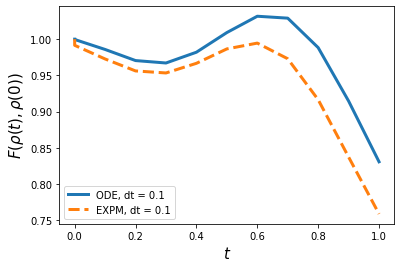

In [13]:
plot_fidelity_evolution(timeslots_1, list_F_ODE_1, list_F_EXPM_1, 0.1)

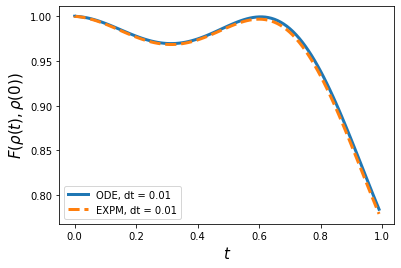

In [14]:
plot_fidelity_evolution(timeslots_2, list_F_ODE_2, list_F_EXPM_2, 0.01)

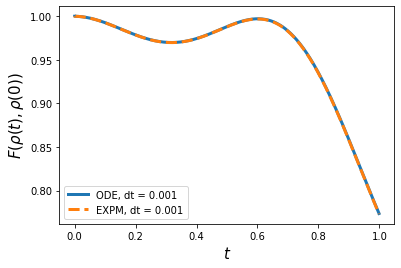

In [15]:
plot_fidelity_evolution(timeslots_3, list_F_ODE_3, list_F_EXPM_3, 0.001)

## 3.2. Генерация случайных чисел

Рассматриваемое состояние $|\psi\rangle = \sqrt{\dfrac{2}{3}} |0\rangle + \sqrt{\dfrac{1}{6}} |10\rangle + i \sqrt{\dfrac{1}{6}} |11\rangle$.

Размерность фоковского пространства, достаточная для моделирования рассматриваемого состояния равна $12$.

Фаза гомодина $\theta = \dfrac{\pi}{10}$.

In [16]:
theta = np.pi / 10

Напишем функции для генерации полиномов Эрмита и функций Чебышева-Эрмита.

In [17]:
def hermit(x, n):
    if n == 0:
        return 1
    elif n == 1:
        return 2 * x
    else:
        return 2 * x * hermit(x, n - 1) - 2 * (n - 1) * hermit(x, n - 2)

In [18]:
def factorial(n):
    fact = 1
    for i in range(2, n + 1):
        fact *= i
    return fact

In [19]:
def hermit_cheb(x, n):
    return (1 / np.sqrt((2 ** n) * factorial(n) * np.sqrt(np.pi))) * hermit(x, n) * np.exp(-(x ** 2) / 2)

Напишем функцию, которая будет выдавать плотность вероятности для квадратуры $x_{\theta}$.

In [20]:
def get_density_probability(x, theta):
    amp_probability_0 = np.sqrt(2 / 3) * hermit_cheb(x, 0) * np.exp(1j * 0 * theta)
    amp_probability_10 = np.sqrt(1 / 6) * hermit_cheb(x, 10) * np.exp(1j * 10 * theta)
    amp_probability_11 = 1j * np.sqrt(1 / 6) * hermit_cheb(x, 11) * np.exp(1j * 11 * theta)
    return np.abs(amp_probability_0 + amp_probability_10 + amp_probability_11) ** 2

Построим график полученной плотности вероятности квадратуры $x_{\theta}$.

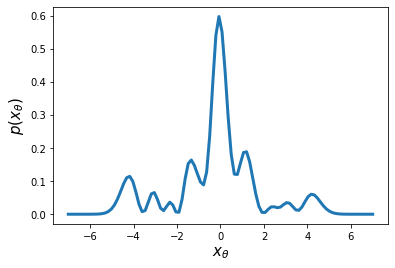

In [21]:
fig, ax = plt.subplots()
x_span = np.linspace(-7, 7, 100)
dens_prob = get_density_probability(x_span, theta)
plt.plot(x_span, dens_prob, lw=3, alpha=1)
ax.minorticks_off()
plt.xlabel(r'$x_{\theta}$', fontsize=15)
plt.ylabel(r'$p(x_{\theta})$', fontsize=15)
plt.show()

Посчитаем функцию распределения квадратуры $x_{\theta}$ по формуле $F(x_{\theta}) = \int_{-\infty}^x p(x_{\theta}) d x_{\theta}$.

In [22]:
from scipy.integrate import quad

In [23]:
def get_func_distr(x, theta):
    prob = quad(lambda x: get_density_probability(x, theta), -100, x)[0]
    return prob

Построим полученную функцию распределения квадратуры $x_{\theta}$.

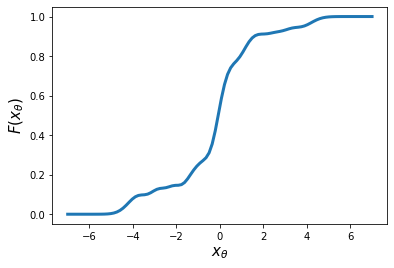

In [24]:
x_span = np.linspace(-7, 7, 100)
func_distr = []
for x in x_span:
    func_distr.append(get_func_distr(x, theta))
func_distr = np.array(func_distr)
fig, ax = plt.subplots()
plt.plot(x_span, func_distr, lw=3, alpha=1)
ax.minorticks_off()
plt.xlabel(r'$x_{\theta}$', fontsize=15)
plt.ylabel(r'$F(x_{\theta})$', fontsize=15)
plt.show()

Произведём интерполяцию обратной функции $F^{-1}(\gamma)$.

In [25]:
from scipy.interpolate import interp1d

In [26]:
inverse_func = interp1d(func_distr, x_span, kind='cubic')

Произведём сэмплирование значений $x_{\theta}$ методом обратной функции.

In [27]:
k = 10000
sample_x_theta = []
for i in range(k):
    F = np.random.rand()
    sample_x_theta.append(inverse_func(F))
sample_x_theta = np.array(sample_x_theta)

Построим гистограмму полученной выборки с плотностью вероятности.

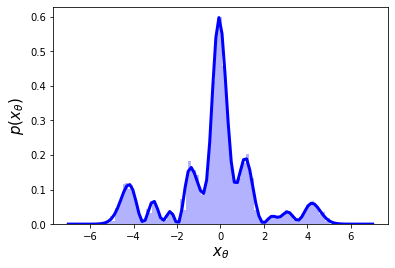

In [28]:
plt.hist(sample_x_theta, bins=100, color='blue', alpha=0.3, density=True)
plt.plot(x_span, dens_prob, color='blue', lw=3, alpha=1)
plt.xlabel(r'$x_{\theta}$', fontsize=15)
plt.ylabel(r'$p(x_{\theta})$', fontsize=15)
plt.show()

Видно, что наблюдается совпадение в хорошей степени.

Перейдём к сэмплированию значений $x_{\theta}$ методом Метрополиса.

Вычисляем дисперсию $\sigma$.

In [29]:
aver_x_2 = quad(lambda x: (x ** 2) * get_density_probability(x, theta), -100, 100)[0]
aver_x = quad(lambda x: x * get_density_probability(x, theta), -100, 100)[0]
sigma = np.sqrt(aver_x_2 - aver_x ** 2)

Выбираем параметр $d = 5 \sigma$.

In [30]:
d = 5 * sigma

Генерируем выборку $x_{\theta}$.

In [31]:
import copy

In [32]:
number_of_iterations = 10
x_k = np.random.randn(k)
for j in range(number_of_iterations):
    g = -0.5 + np.random.rand(k)
    gamma = np.random.rand(k)
    x_tmp = copy.copy(x_k)
    x_k += d * g
    # print(get_density_probability(x_tmp, theta) < 10 ** (-30))
    index = np.where(get_density_probability(x_k, theta) <= get_density_probability(x_tmp, theta) * gamma)[0]
    x_k[index] = x_tmp[index]
sample_x_theta_metropolis = x_k

Построим гистограмму полученной выборки с плотностью вероятности.

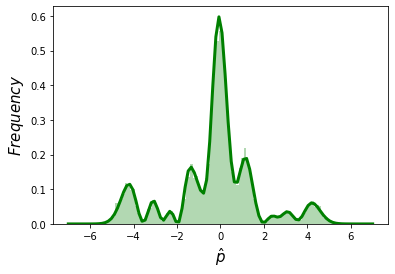

In [33]:
plt.hist(sample_x_theta_metropolis, bins=100, color='green', alpha=0.3, density=True)
plt.plot(x_span, dens_prob, color='green', lw=3, alpha=1)
plt.xlabel(r'$\hat{p}$', fontsize=15)
plt.ylabel(r'$Frequency$', fontsize=15)
plt.show()

Видно, что наблюдается совпадение в хорошей степени.